In [1]:
import rawpy
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

import helper


In [2]:


import numpy as np
import argparse
from pathlib import Path
import tifffile as tiff
import cv2  # For saving JPG files
import time  # For performance timing
import rawpy  # For reading RAW files
import os  # For file extension handling

Save=False

In [3]:
img_path = 'data/Scans_light source1_negative_raw/DSCF7391.RAF'
print(os.path.exists(img_path))
raw_neg = rawpy.imread(img_path)
input_image = raw_neg.postprocess(
                    gamma=(1, 1),  # Linear output
                    no_auto_bright=True,
                    output_bps=16,
                    user_wb=[1, 1, 1, 1]  # No white balance adjustment
                ).astype(np.float32) / 65535.0  # Normalize to [0, 1]

True


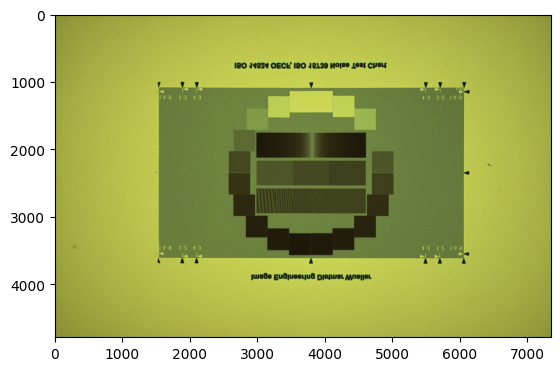

In [4]:
#get rid of boundaries 

demosaic_raw = input_image[200:-200,200:-200,:]
#blurred_img = cv2.GaussianBlur(demosaic_raw.copy(), (5, 5), 0)
plt.imshow(demosaic_raw/demosaic_raw.max())


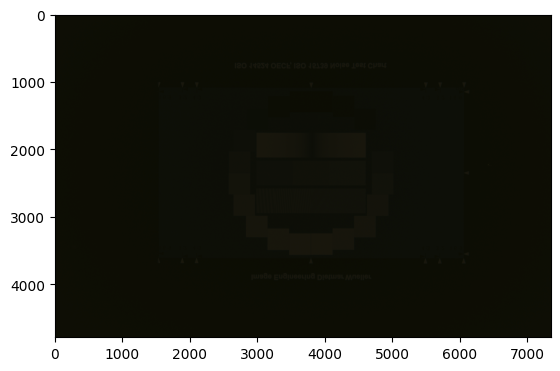

In [5]:
density = helper.calculate_film_density(demosaic_raw.copy())
density = helper.uncorrelate_densities(density)
density = np.clip(density, 0, 12)
plt.imshow((density-density.min())/(density.max()-density.min()))

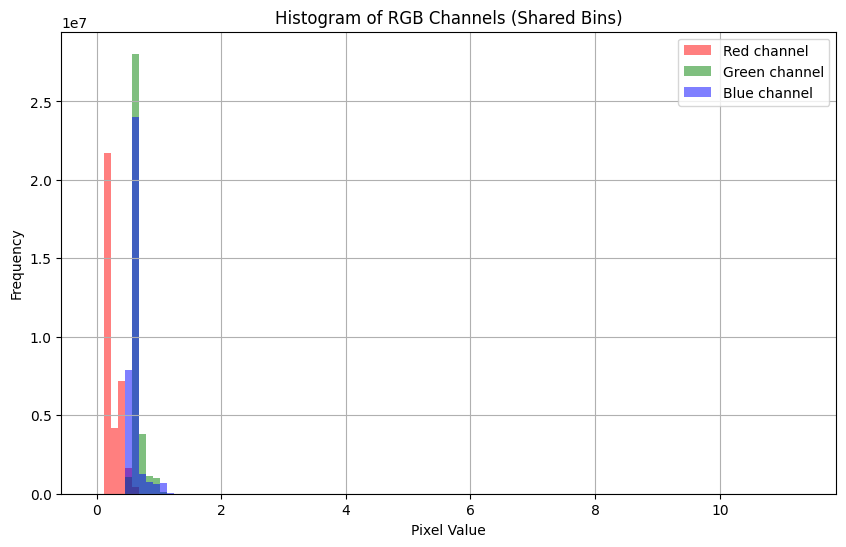

Max values: 11.303057670593262 6.0 6.0
Min values: 0.4269300699234009 0.4897257685661316 0.0


In [6]:
helper.hist_channel(density.copy())

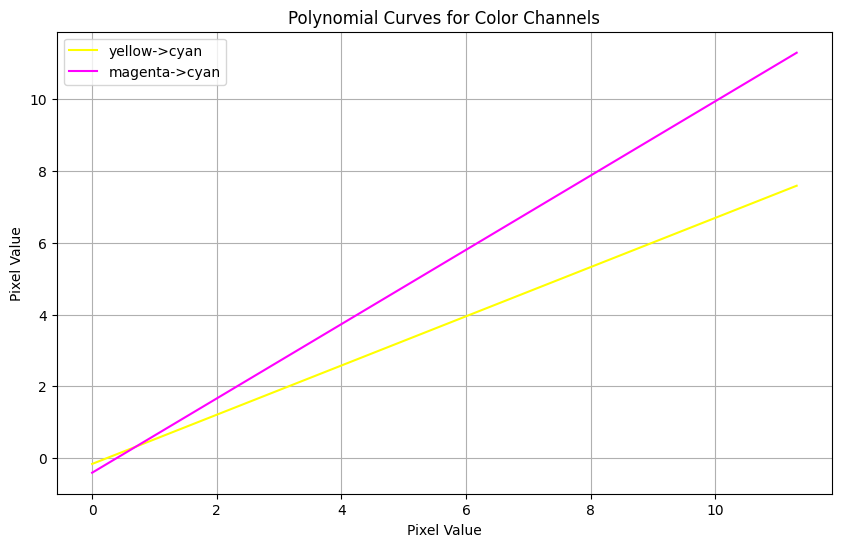

In [ ]:
p02,p12 = helper.uncor_fit_poly(density,order=1)
helper.uncor_show_fit(p02,p12)


In [8]:
img_corrected = helper.uncor_interpolate_img(density.copy(),p02,p12)

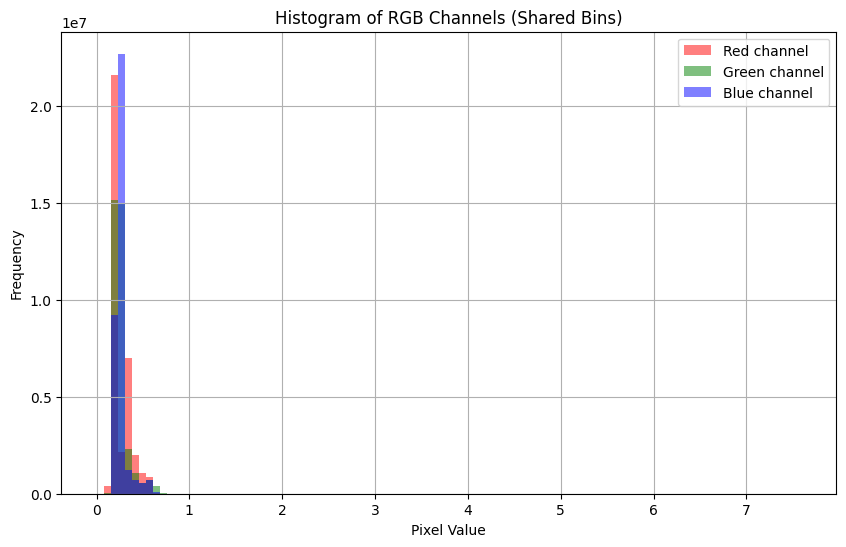

Max values: 7.587899465399177 5.8036888631196275 6.0
Min values: 0.13020664166074658 0.09970247786073783 0.0


In [9]:
helper.hist_channel(img_corrected)


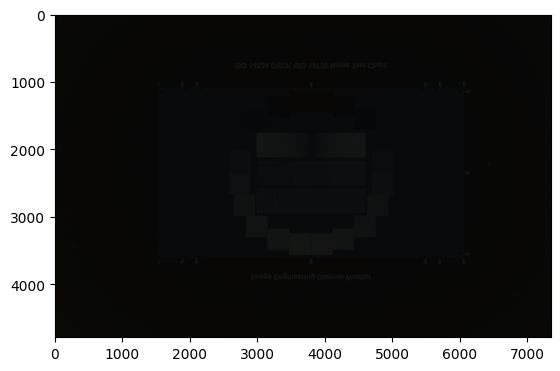

In [10]:
plt.imshow(img_corrected/img_corrected.max())

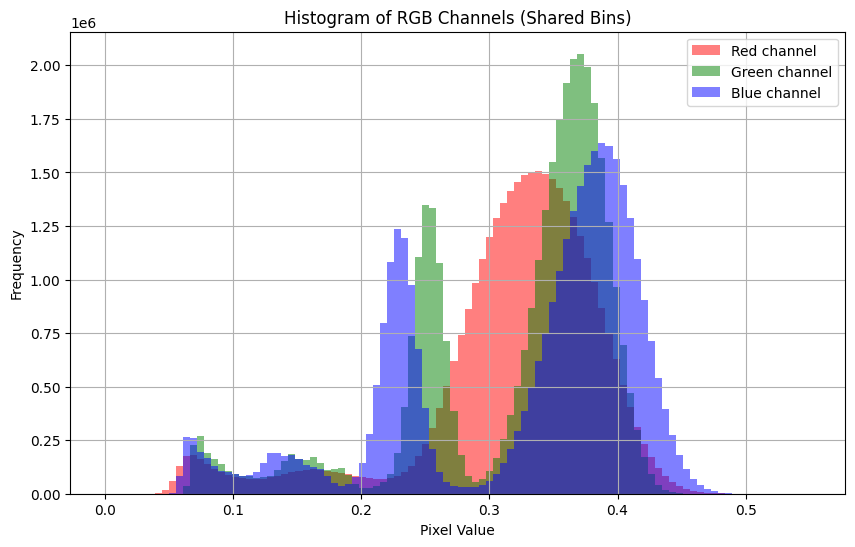

Max values: 0.5312993298720724 0.47423884332192046 0.5501422767324041
Min values: 1.5714882454030688e-12 1.1178256884702929e-10 1.7566499298406578e-10


In [11]:
img_corrected_correlated = helper.get_correlated_densities(img_corrected.copy())
reflectance = helper.get_reflectance_from_density(img_corrected_correlated.copy())
helper.hist_channel(reflectance)


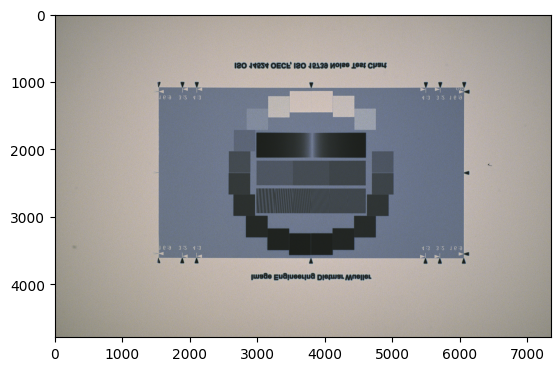

In [12]:
plt.imshow(reflectance/reflectance.max())


True


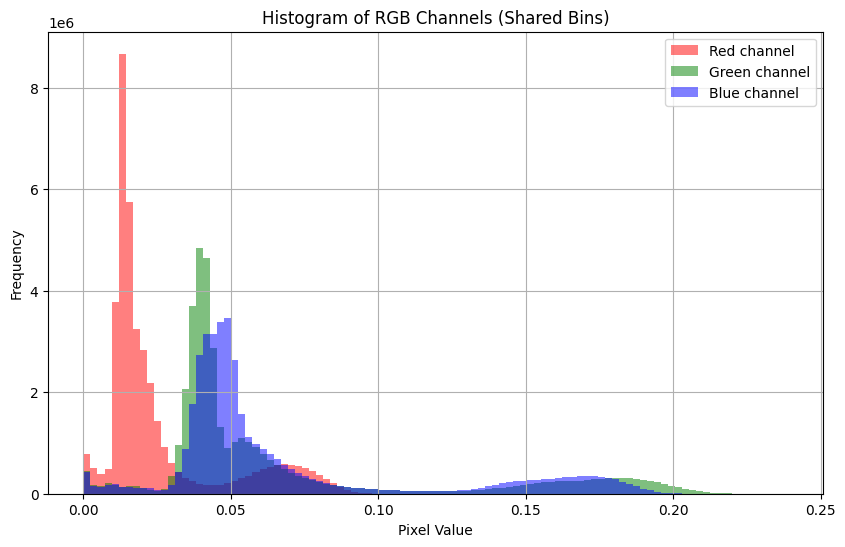

Max values: 0.2232395 0.23892577 0.11926451
Min values: 0.0 0.0 0.0


In [13]:
dir_path = 'data/Scans_light source1_negative_raw/'
img_path = os.path.join(dir_path, 'DSCF7373.RAF')
print(os.path.exists(img_path))
raw_neg = rawpy.imread(img_path)
        
demosaic_raw = raw_neg.postprocess(
                    gamma=(1, 1),  # Linear output
                    no_auto_bright=True,
                    output_bps=16,
                    user_wb=[1, 1, 1, 1]  # No white balance adjustment
                ).astype(np.float32) / 65535.0  # Normalize to [0, 1]
helper.hist_channel(demosaic_raw)


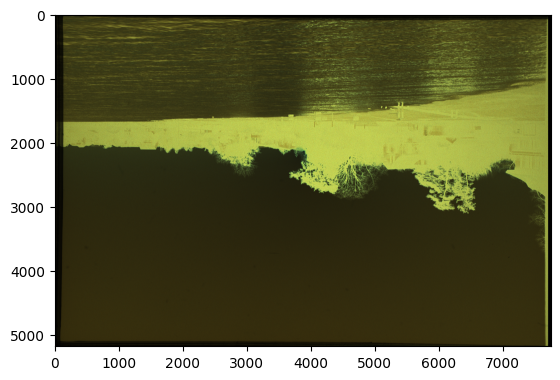

In [14]:
plt.imshow(demosaic_raw/demosaic_raw.max())

In [15]:
print(p02.coef)
print(p12.coef)

[3.85905305 3.72884641]
[2.95169567 2.85199319]


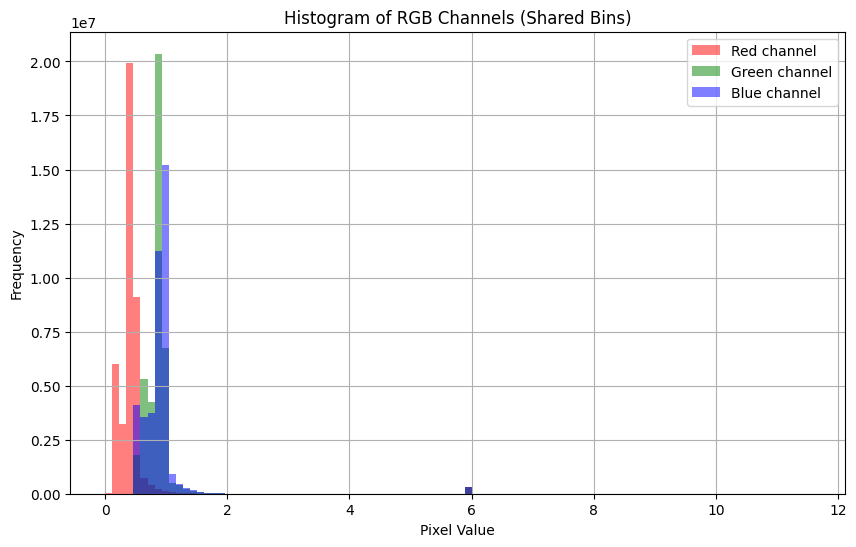

Max values: 11.53919792175293 10.685523986816406 11.359915733337402
Min values: 0.0 0.0 0.0


In [16]:

densities = helper.calculate_film_density(demosaic_raw.copy())
densities = helper.uncorrelate_densities(densities)
densities = np.clip(densities, 0, 12)
helper.hist_channel(densities)


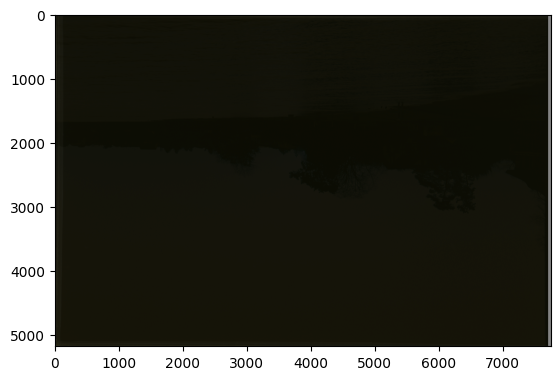

In [17]:
plt.imshow(densities/densities.max())


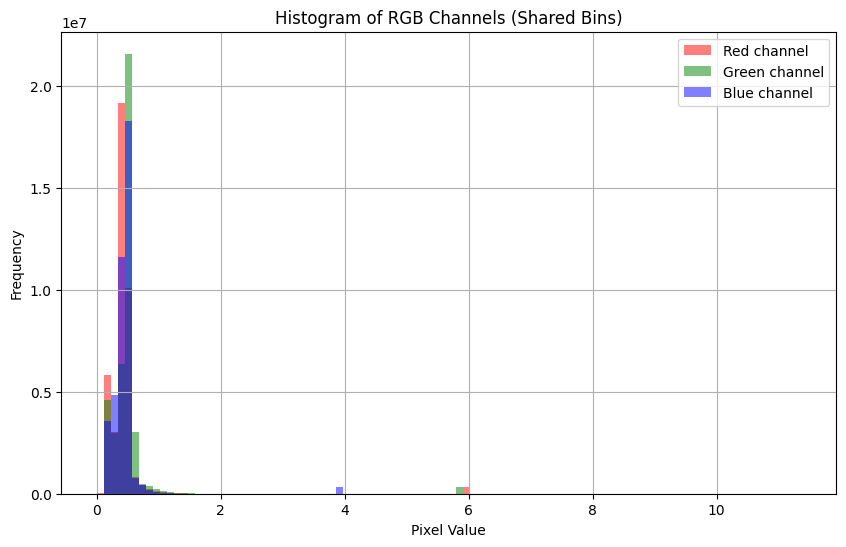

Max values: 7.749819361995534 10.653931138929217 11.359915733337402
Min values: 0.0 0.0 0.0


In [18]:
c_img = helper.uncor_interpolate_img(densities.copy(),p02,p12)
c_img = np.clip(c_img,0,12)
helper.hist_channel(c_img)

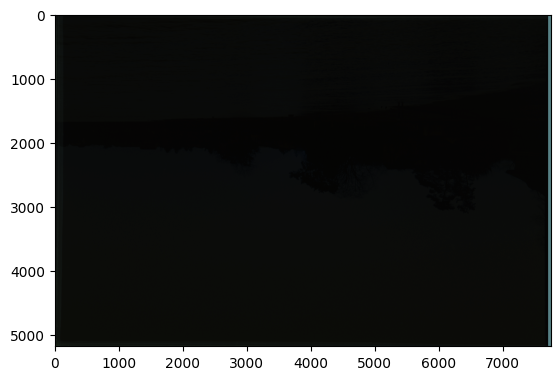

In [19]:
plt.imshow(c_img/c_img.max())


In [20]:
correlated_density = helper.get_correlated_densities(c_img.copy())

clipped_density = np.clip(correlated_density, 0, 12)

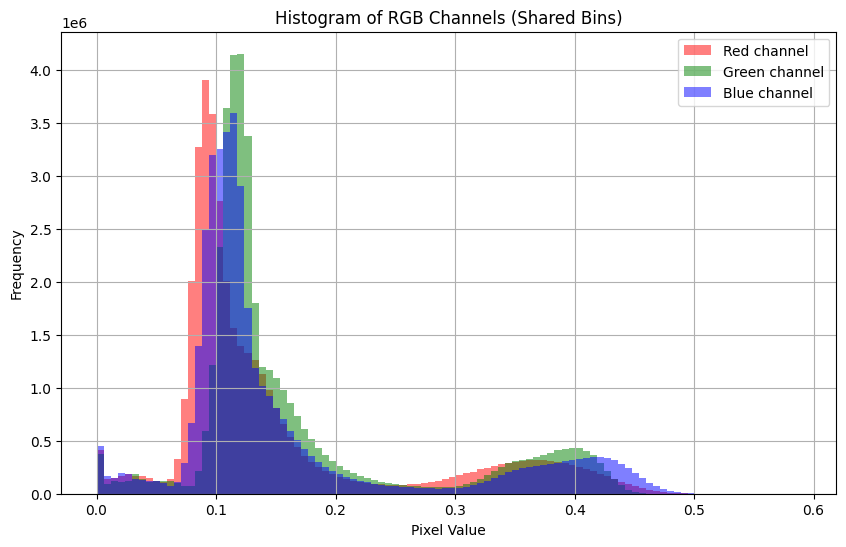

Max values: 0.547349423472481 0.4873448875626108 0.5894891264236598
Min values: 1.075456497834721e-12 2.310573437758821e-12 4.048344895810132e-12


In [21]:
reflectance = helper.get_reflectance_from_density(clipped_density.copy())
helper.hist_channel(reflectance)


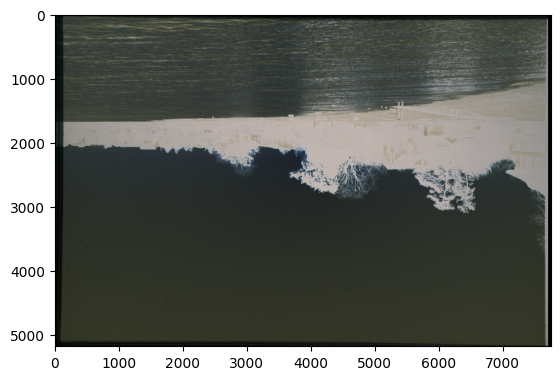

In [22]:
plt.imshow(reflectance/reflectance.max())


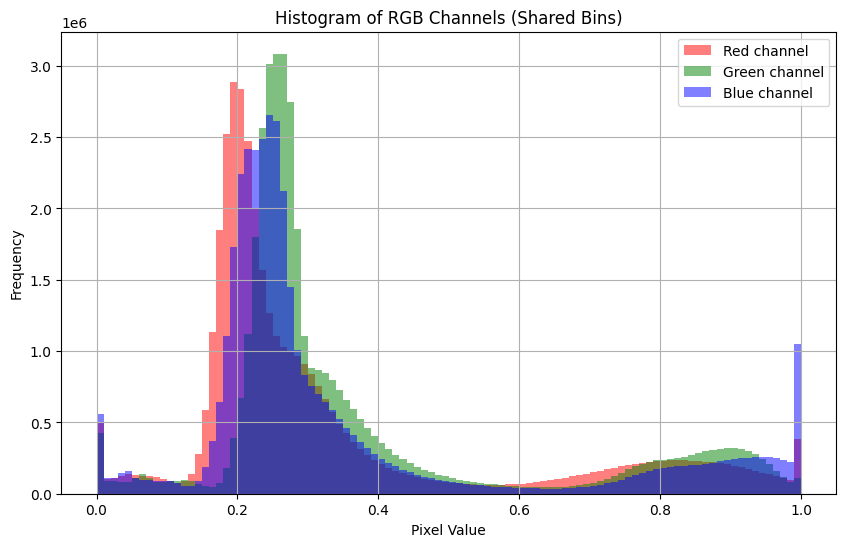

Max values: 1.0 1.0 1.0
Min values: 0.0 0.0 0.0


In [23]:
reflectance = helper.rescale_image_globally(reflectance)
helper.hist_channel(reflectance)


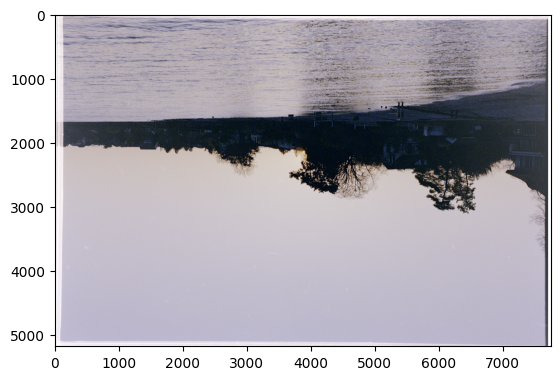

In [24]:
plt.imshow((1-reflectance)/(1-reflectance).max())


In [29]:
if(Save):
    dir_path = 'data/Scans_light source1_negative_raw/'
    save_path = 'data/density_corrected_uncorr2/'
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    for file_name in os.listdir(dir_path):
        if file_name.endswith('.RAF'):
            img_path = os.path.join(dir_path, file_name)
            print('working on: ' ,  file_name)    
            print(os.path.exists(img_path))
            raw_neg = rawpy.imread(img_path)
            
            demosaic_raw = raw_neg.postprocess(
                        gamma=(1, 1),  # Linear output
                        no_auto_bright=True,
                        output_bps=16,
                        user_wb=[1, 1, 1, 1]  # No white balance adjustment
                    ).astype(np.float32) / 65535.0  # Normalize to [0, 1]
            img = helper.correct_images_by_decorrelating(demosaic_raw.copy(),p02,p12)
            img = 1-img
            img = cv2.cvtColor(img.astype(np.float32), cv2.COLOR_BGR2RGB)
            save_file_name = os.path.splitext(file_name)[0] + '.tiff'
            save_file_path = os.path.join(save_path, save_file_name)

            cv2.imwrite(save_file_path, img.astype(np.float32))
            
            
        


working on:  DSCF7373.RAF
True
working on:  DSCF7367.RAF
True
working on:  DSCF7366.RAF
True


KeyboardInterrupt: 

In [27]:
Save=True

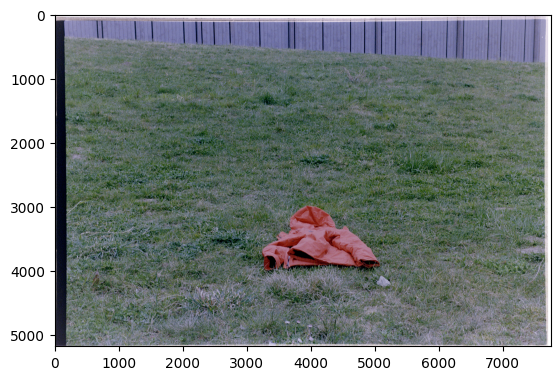

In [31]:
dir_path = 'data/Scans_light source1_negative_raw/'
file_name = "DSCF7387.RAF"
img_path = os.path.join(dir_path, file_name)
raw_neg = rawpy.imread(img_path)          
demosaic_raw = raw_neg.postprocess(
                        gamma=(1, 1),  # Linear output
                        no_auto_bright=True,
                        output_bps=16,
                        user_wb=[1, 1, 1, 1]  # No white balance adjustment
                    ).astype(np.float32) / 65535.0  # Normalize to [0, 1]
img = helper.correct_images_by_decorrelating(demosaic_raw.copy(),p02,p12)
img = 1-img

plt.imshow(img)

In [35]:
def open_process(dir_path,file_name,p02,p12):
    
    img_path = os.path.join(dir_path, file_name)
    raw_neg = rawpy.imread(img_path)          
    demosaic_raw = raw_neg.postprocess(
                            gamma=(1, 1),  # Linear output
                            no_auto_bright=True,
                            output_bps=16,
                            user_wb=[1, 1, 1, 1]  # No white balance adjustment
                        ).astype(np.float32) / 65535.0  # Normalize to [0, 1]
    img = helper.correct_images_by_decorrelating(demosaic_raw.copy(),p02,p12)
    img = 1-img
    plt.imshow(img)


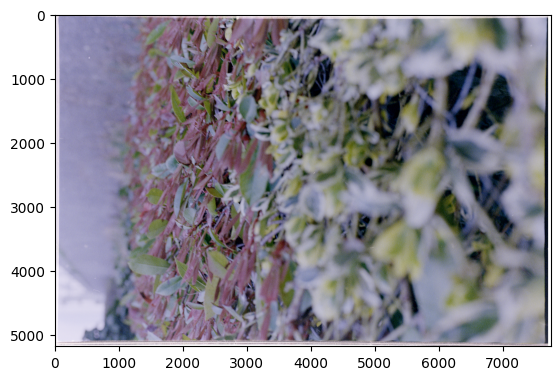

In [36]:
dir_path = 'data/Scans_light source1_negative_raw/'
file_name = "DSCF7371.RAF"
open_process(dir_path,file_name,p02,p12)

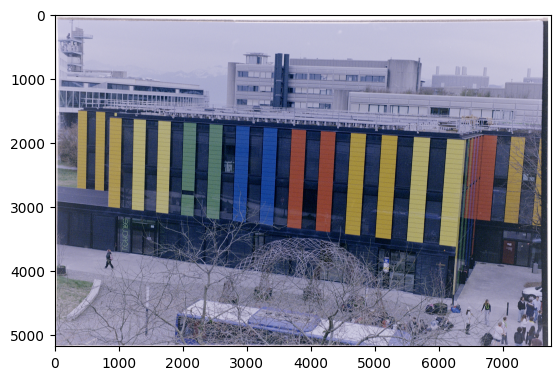

In [37]:
dir_path = 'data/Scans_light source1_negative_raw/'
file_name = "DSCF7378.RAF"
open_process(dir_path,file_name,p02,p12)

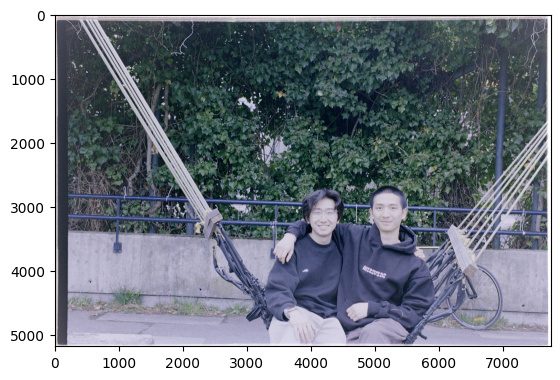

In [38]:
dir_path = 'data/Scans_light source1_negative_raw/'
file_name = "DSCF7386.RAF"
open_process(dir_path,file_name,p02,p12)

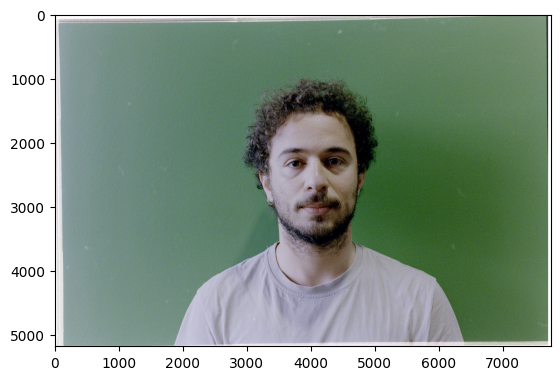

In [39]:
dir_path = 'data/Scans_light source1_negative_raw/'
file_name = "DSCF7380.RAF"
open_process(dir_path,file_name,p02,p12)

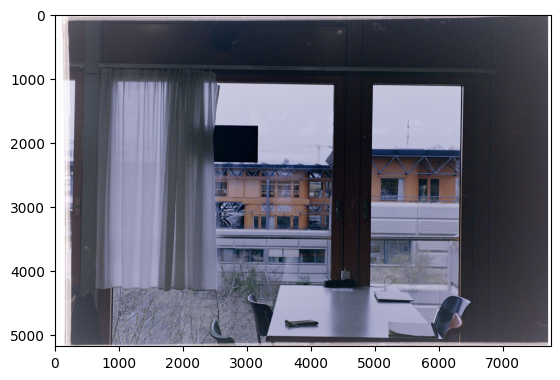

In [40]:
dir_path = 'data/Scans_light source1_negative_raw/'
file_name = "DSCF7379.RAF"
open_process(dir_path,file_name,p02,p12)

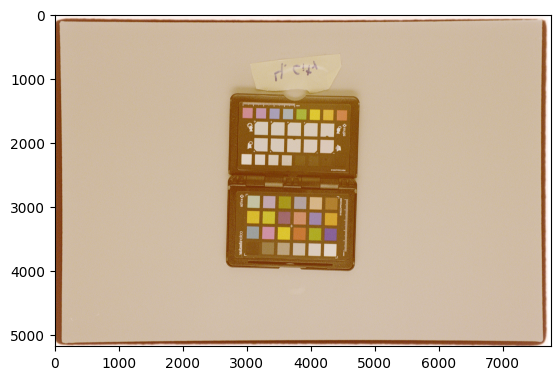

In [42]:
#light source 2
dir_path = 'data/Scans-lightsource2-raw/'
file_name = "DSCF7403.RAF"
open_process(dir_path,file_name,p02,p12)

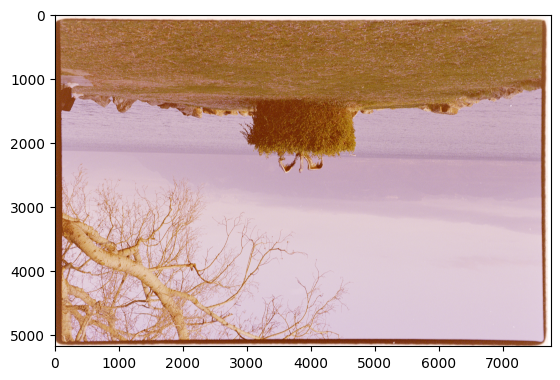

In [43]:
dir_path = 'data/Scans-lightsource2-raw/'
file_name = "DSCF7417.RAF"
open_process(dir_path,file_name,p02,p12)

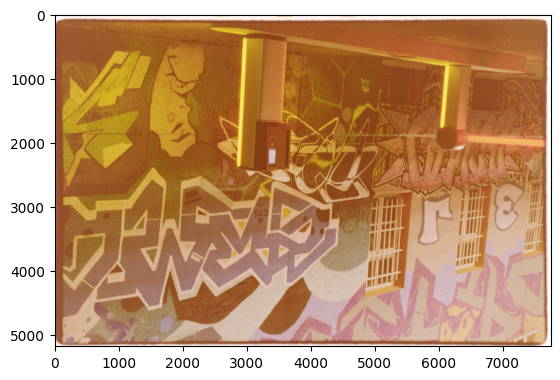

In [44]:
dir_path = 'data/Scans-lightsource2-raw/'
file_name = "DSCF7428.RAF"
open_process(dir_path,file_name,p02,p12)

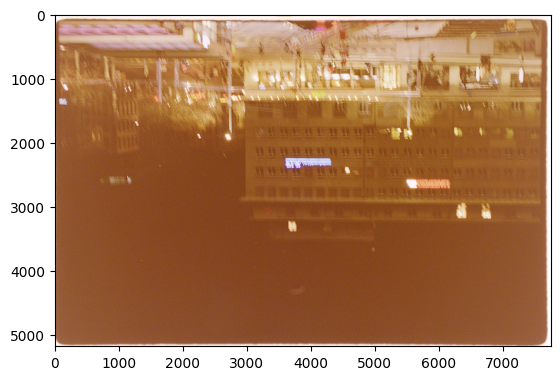

In [45]:
dir_path = 'data/Scans-lightsource2-raw/'
file_name = "DSCF7431.RAF"
open_process(dir_path,file_name,p02,p12)